In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import nrrd
import glob

from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
from nibabel.affines import from_matvec, to_matvec, apply_affine
from nibabel.processing import resample_to_output, resample_from_to
import numpy.linalg as npl

from nilearn.image import resample_img

In [2]:
# !pip install nilearn

## Variables

In [3]:
DATASET = 'NAKO' # 'NAKO', 'UKB', 'KORANAKOUKB'
DEFAULT_FILE_TYPE = 'nifti'  # 'nerd'
TARGET_FILE_TYPE = 'nifti'
DEFAULT_ORIENTATION = 'RAS'
TARGET_RESOLUTION = [2,2,3]
DEFAULT_VIEW = ['Saggital', 'Coronal', 'Axial']
DEFAULT_REFERENCE_VIEW = 'Sagittal'
OPTIMIZATION = 'N4'  # Intensity, Min-Max, Fat-Water-Swap
IS_CROPPING = True
DEFAULT_WORLD_COORDS = [500, 500, 1000]
DEFAULT_OUTPUT_PATH = './temp'
DEFAULT_LINSPACE = 30

FILE_TO_LABEL_MAP =  {'BACKGROUND': 'background','LIVER': 'liver', 'SPLEEN': 'spleen','KIDNEY(RIGHT)':'kidney_r',
                      'KIDNEY(LEFT)':'kidney_l', 'ADRENALGLAND':'adrenal', 'PANCREAS': 'pancreas',
                      'GALLBLADDER': 'gallbladder', 'SUBCUTANEOUS':'subcutaneous', 'THYROIDGLAND':'thyroid_gland'}

## Utilities

In [4]:
def create_if_not(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Creating the default paths needed for smooth execution.
create_if_not(DEFAULT_OUTPUT_PATH)

def volume_viewer(vol, axis_idx=0):
    if axis_idx > 2:
        raise Exception('Axis Index cannot be more than 2! Ideally 0: Sagittal, 1: Coronal, 2: Axial.')
    axis = vol.shape
    plt.imshow(vol[axis[axis_idx]//2])
    plt.show()
    
def volume_3_view_viewer(vol):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True)
    axis = vol.shape
    
    ax1.imshow(vol[axis[0]//2])
    ax2.imshow(vol[:, axis[1]//2, :])
    ax3.imshow(vol[:, :, axis[2]//2])
    
    plt.show()
    
def get_volume_data(img):
    print(f"Affine:{img.affine}, Image Shape: {img.shape}")
    return img.get_fdata()

def save_volume(img, file_name):
    nb.save(img, f'{DEFAULT_OUTPUT_PATH}/{file_name}.nii.gz')
    
def sigmoid(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = 1 / (1 + np.exp(-x[i]))
    return y

def normalise_data(volume):
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    return volume

## Volume Loader / Reader

In [5]:
def post_interpolate(volume, labelmap=None, target_shape=[256,256,128]):
    volume = do_cropping(volume, target_shape)
    if labelmap is not None:
        labelmap = do_cropping(labelmap, target_shape)
    current_shape = volume.shape
    intended_shape_deficit = target_shape - np.asarray(current_shape)

    paddings = [tuple(
        np.array([np.ceil((pad_tuples / 2) - pad_tuples % 2), np.floor((pad_tuples / 2) + pad_tuples % 2)]).astype(
            'int32')) for pad_tuples in intended_shape_deficit]
    paddings = tuple(paddings)

    volume = np.pad(volume, paddings, mode='constant')
    if labelmap is not None:
        labelmap = np.pad(labelmap, paddings, mode='constant')

    return volume, labelmap

def do_cropping(source_num_arr, bounding):
    start = list(map(lambda a, da: a // 2 - da // 2, source_num_arr.shape, bounding))
    end = list(map(operator.add, start, bounding))
    for i, val in enumerate(zip(start, end)):
        if val[0] < 0:
            start[i] = 0
            end[i] = source_num_arr.shape[i]
    slices = tuple(map(slice, tuple(start), tuple(end)))
    return source_num_arr[slices]

def drop_overlapped_pixels(labelmap, availed_manual_segs_id_list, no_of_class):
    present_seg_idxs = np.unique(labelmap)
    overlapped_seg_idxs = set(present_seg_idxs).difference(availed_manual_segs_id_list)

    for idxs in overlapped_seg_idxs:
        print(f'Overlapped Idxs Found, removing it for idx {idxs}')
        labelmap[labelmap == idxs] = 0
    return labelmap

def fetch_class_labels_from_filemap(labelmap_path, file_labels):
    label_idx, label = None, None
    for lidx, file_label in enumerate(file_labels):
        if file_label in labelmap_path.replace(" ", "").upper():
            label_idx, label = lidx, file_label
            break
    return label_idx, label

In [6]:
def nrrd_reader(file_path):
    print("Reading NRRD Files.....")
    _nrrd = nrrd.read(file_path)
    data = _nrrd[0]
    header = _nrrd[1]
    return data, header, None

def nibabel_reader(file_path):
    print("Reading Nifti Files.....")
    volume_nifty = nb.load(file_path)
    volume = get_volume_data(volume_nifty)
    return volume, volume_nifty.header, volume_nifty

def file_reader(file_path, file_type=None):
    print('Reading Files.....')
    header_mat = np.empty_like((4,4))
    if file_type == None:
        file_type = file_path.split('.')[-1]
    if file_type == 'nrrd':
        data, header, img = nrrd_reader(file_path)
        affine = header['space directions']
        affine = affine[:3, :3]
        origins = header['space origin']
        origins = origins[:3]
        t_mat = from_matvec(affine, origins)
        img = nb.Nifti1Image(data, t_mat) if img is None else img
        header_mat = t_mat
    else:
        data, header, img = nibabel_reader(file_path)
        header_mat = header
    
    return data, header_mat, img

def remove_black(volume):
    print("Removing Black Slices.....")
    clean_data = []
    for i, frame in enumerate(volume):
        unique, counts = np.unique(frame, return_counts=True)
        if counts[0] / sum(counts) < .99:
            clean_data.append(frame)
    return np.array(clean_data)

## Transformation :- Reading Direction Optimization

In [95]:
def do_nibabel_transform_to_ras(img):
    print(f'Transforming Images to {DEFAULT_ORIENTATION}.....')
    affine = img.affine
    orig_ornt = nb.io_orientation(affine)
    targ_ornt = axcodes2ornt(DEFAULT_ORIENTATION)
    transform = ornt_transform(orig_ornt, targ_ornt)
    img = img.as_reoriented(transform)
    return img

def multi_vol_stitching(images, is_label=False):
    if len(images)==1:
        return images
    elif len(images) ==0:
        raise Exception("Empty Image List!")
        
    images_sorted = sorted(images, key=lambda im: im.header['qoffset_z'], reverse=True)
    img_0 = images_sorted[0]
    
    mode = 'nearest' if is_label else 'constant'
    img_0 = resample_to_output(img_0, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    
    for idx, img_1 in enumerate(images_sorted[1:]):
        print(f'{idx}th img for stitching...')
#         print("STARTTTTT: ", img_1.affine)
        img_1 = resample_to_output(img_1, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#         img_1 = placing_axes(img_1, img_0.affine.copy(), img_0.header.copy(), [2])
#         print( img_1.affine)
        target_affine = img_0.affine.copy()
        target_affine[2,3] = img_1.affine[2,3].copy()
        target_shape = img_0.shape[:2] + img_1.shape[2:]
#         img_1 = placing_axes(img_1, target_affine, img_0.header.copy(), skip_axis=[2])
        img_1 = resample_from_to(img_1, [target_shape, target_affine])
#         print(img_1.affine)
        img_0 = vol_stitching(img_0, img_1)
#         print(img_0.affine, 'FINISHHHHHHHHH')
        
    return img_0
    
def vol_stitching(im_0, im_1):
    im_0_z = im_0.shape[2]
    im_1_z = im_1.shape[2]

    # calculate overlap region:
    im_0_end = im_0.header['qoffset_z']
    im_1_end = im_1.header['qoffset_z']

    spacing = im_0.header['pixdim'][3]

    im_0_width = im_0_z * spacing
    im_1_width = im_1_z * spacing

    im_1_start = im_1_end + im_1_width
    im_0_start = im_0_end + im_0_width

    overlap = abs(im_0_end - im_1_start)

    overlap_v = int(round(overlap / spacing))

    new_im_dim = abs(round((abs(im_1_end - im_0_start)) / spacing))

    new_img = np.empty([im_0.shape[0], im_0.shape[1], int(new_im_dim)])

    im_0_data = im_0.get_fdata()
    im_1_data = im_1.get_fdata()

    new_img[:, :, 0:(im_1_z - overlap_v)] = im_1_data[:, :, 0:(im_1_z - overlap_v)]
    new_img[:, :, im_1_z:] = im_0_data[:, :, overlap_v:]
    
    # overlap region:
    sigmoid_c = sigmoid(np.linspace(-DEFAULT_LINSPACE, DEFAULT_LINSPACE, overlap_v))
    
    for l in range(0, overlap_v):
        new_img[:, :, (im_1_z - overlap_v + l)] = \
        (1 - sigmoid_c[l]) * im_1_data[:,:, (im_1_z - overlap_v) + l] + (sigmoid_c[l]) * im_0_data[:, :, l]
        
    stitched_img = nb.Nifti1Image(new_img, im_1.affine, im_1.header)
#     placing_axes(stitched_img)
    return stitched_img

def read_ras(file_path, file_type=None, is_label=False):
    _, _, img = file_reader(file_path, file_type)
    img_ras = do_nibabel_transform_to_ras(img)
    if is_label:
        file_labels = list(FILE_TO_LABEL_MAP.keys())
        lidx, labelname = fetch_class_labels_from_filemap(file_path, file_labels)
        return img_ras, lidx, labelname
    else:
        return img_ras

def fetch_class_labels_from_filemap(labelmap_path, file_labels):
    label_idx, label = None, None
    for lidx, file_label in enumerate(file_labels):
        if file_label in labelmap_path.replace(" ", "").upper():
            label_idx, label = lidx, file_label
            break
    return label_idx, label


def placing_axes(vol, target_affine, target_header=None, skip_axis=None):
    
    vol2target = npl.inv(target_affine).dot(vol.affine)
    source_data = vol.get_fdata()
    shifts = tuple(vol2target[:3, 3].astype(np.int32))
    print(shifts)
#     print(source_data.shape)
    for ax, shift in enumerate(shifts):
        if skip_axis is not None and ax in skip_axis:
            continue
        print(ax, shift)
        shift = int(shift)
        if shift < 0:
            source_data = flip_axis(source_data, axis=ax)
        print(-np.abs(shift))
        source_data = np.roll(source_data, -np.abs(shift), axis=ax)
                
    if target_header is None:
        target_header = nb.Nifti1Header()
    stitched_labeled_img = nb.Nifti1Image(source_data, target_affine, target_header)

    return stitched_labeled_img


def label_stitching(label_parts, img_reference):
    header = img_reference.header
    target_affine = img_reference.affine
    steps = header['pixdim'][1:4]
    volume = img_reference.get_fdata()
    im_dim_v = volume.shape
    
    processed_segm = None #np.zeros((500,500,1000))

    im_offx = abs(header['qoffset_x'])
    im_offy = abs(header['qoffset_y'])
    im_offz = abs(header['qoffset_z'])
    q_offsets = [im_offx,im_offy,im_offz]
    
    reference_labelmap = None
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)

        if reference_labelmap is None:
            reference_labelmap = labelmap_img
        else:
            mode = 'nearest'
            labelmap_img = resample_from_to(labelmap_img, [reference_labelmap.shape, reference_labelmap.affine], mode=mode)
            print('c shape:', labelmap_img.shape, labelmap_img.affine)
            
        label_header = labelmap_img.header
        labelmap = labelmap_img.get_fdata()
        labelmap_affine = labelmap_img.affine
        steps_l = label_header['pixdim'][1:4]
        lblmp_offx = abs(label_header['qoffset_x'])
        lblmp_offy = abs(label_header['qoffset_y'])
        lblmp_offz = abs(label_header['qoffset_z'])
        q_offsets_l = [lblmp_offx,lblmp_offy,lblmp_offz]
        
        print(f'vol offsets: {q_offsets}')
        
        print(f'label_offsets: {q_offsets_l}')
        
#         l_vol = np.prod(labelmap.shape)
        segm_dim_v = labelmap.shape
        
        ############
        labelmap2vol = npl.inv(target_affine).dot(labelmap_affine)
        seg_start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
        seg_end_inv = apply_affine(labelmap2vol, segm_dim_v).astype(np.int32)
        print("seg start inv v: ",seg_start_inv , "segm end inv v:",seg_end_inv)
        ############
#         shifts = tuple(np.floor(labelmap2vol[:3, 3]).astype(np.int32))
        for ax, shift in enumerate(seg_start_inv):
            print(ax, shift)
            shift = int(shift)
            if True:
                if ax in [0,2]:
                    labelmap = flip_axis(labelmap, axis=ax)
                if shift < 0:
#                     labelmap = flip_axis(labelmap, axis=ax) #if ax == 1 else labelmap
                    seg_end_inv[ax] += abs(seg_start_inv[ax])
                    seg_start_inv[ax] = 0
                else:
#                     labelmap = flip_axis(labelmap, axis=ax)
                    seg_end_inv[ax] -= abs(seg_start_inv[ax])
                    seg_start_inv[ax] = 0
            
        print("updated seg start inv v: ",seg_start_inv , "updated segm end inv v:",seg_end_inv)
        labelmap = np.multiply(lidx, labelmap)
        
        if processed_segm is None:
            seg_vol = np.prod(seg_end_inv)
            vol_vol = np.prod(volume.shape)
            print("inside seg start inv v: ",seg_start_inv , "inside segm end inv v:",seg_end_inv)
            print(f'seg vol: {seg_vol}, vol vol: {vol_vol}')
            processed_segm = np.zeros(seg_end_inv) if seg_vol>vol_vol else np.zeros(volume.shape)
            print("proceess shape:", processed_segm.shape)
            
        processed_segm[seg_start_inv[0]:seg_end_inv[0], seg_start_inv[1]:seg_end_inv[1], seg_start_inv[2]:seg_end_inv[2]] += labelmap
        print("###############################################################################################")

#     print(volume.shape, processed_segm.shape)
#     processed_segm = np.flip(processed_segm)
    labelmap = np.round(processed_segm)
    empty_header = nb.Nifti1Header()
#     processed_segm_img = nb.Nifti1Image(processed_segm, target_affine, empty_header)
#     processed_segm = resample_from_to(processed_segm_img, [volume.shape, target_affine])
    
    
#     volume_ = np.zeros_like(processed_segm)
#     vx, vy, vz = volume.shape
#     volume_[0:vx, 0:vy, 0:vz] = volume
#     volume = volume_
#     volume = np.flip(np.moveaxis(volume, 2, 1))  # 012 -> 021
#     labelmap = np.flip(np.moveaxis(labelmap, 2, 1))
    volume = normalise_data(volume)

    print("shape label:", labelmap.shape)
    stitched_labeled_img = nb.Nifti1Image(labelmap, target_affine, empty_header)
    volume_img = nb.Nifti1Image(volume, target_affine, empty_header)
    
    return volume_img, stitched_labeled_img
    

5 ADRENALGLAND
vol offsets: [221.36977, 172.9664, 688.6573]
label_offsets: [261.92883, 362.3331, 210.32397]
seg start inv v:  [-21 -95 159] segm end inv v: [220  39 323]
0 -21
1 -95
2 159
updated seg start inv v:  [0 0 0] updated segm end inv v: [241 134 164]
inside seg start inv v:  [0 0 0] inside segm end inv v: [241 134 164]
seg vol: 5296216, vol vol: 8054778
proceess shape: (246, 137, 239)
###############################################################################################
7 GALLBLADDER
c shape: (241, 134, 164) [[   2.            0.            0.         -261.92883301]
 [   0.            2.            0.         -362.33310068]
 [   0.            0.            3.         -210.32397461]
 [   0.            0.            0.            1.        ]]
vol offsets: [221.36977, 172.9664, 688.6573]
label_offsets: [261.92883, 362.3331, 210.32397]
seg start inv v:  [-21 -95 159] segm end inv v: [220  39 323]
0 -21
1 -95
2 159
updated seg start inv v:  [0 0 0] updated segm end inv v: 

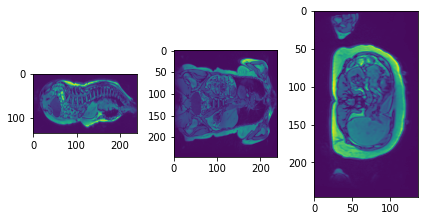

Affine:[[   2.            0.            0.         -221.3697629 ]
 [   0.            2.            0.         -172.96640778]
 [   0.            0.            3.         -688.65729654]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


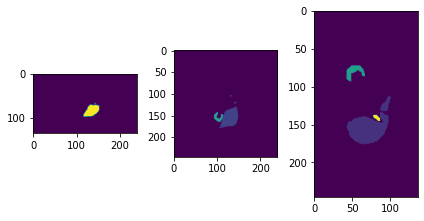

Saving Processed & Stitched Image.....
FINISHED.


In [96]:
volume = img_ras_sampled_combined
volume, stitched_label = label_stitching(img_ras_list[1:], volume)

mode='nearest'
stitched_label_a = resample_from_to(stitched_label, [volume.shape, volume.affine], mode=mode)
print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(volume))
volume_3_view_viewer(get_volume_data(stitched_label_a))

print('Saving Processed & Stitched Image.....')
save_volume(volume, 'kora_volume')
save_volume(stitched_label_a, 'kora_label')
print('FINISHED.')

STARTING KORA.
Reading Volumes.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         266.92883301]
 [  0.           0.          -1.69999695  97.33310699]
 [  0.          -1.70138884   0.          24.67601776]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          261.92883301]
 [   0.            0.           -1.69999695   97.33310699]
 [   0.           -1.66666663    0.         -210.32397461]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Merging/Stitching Images.....
0th img for stitching...
Viewing Stitched Images.....
Affine:[[   2.            0.            0.         -221.3697629 ]
 [   0.            2.            0.         -172.96640778]
 [   0.            0.            3.         -688.65729654]
 [   0.     

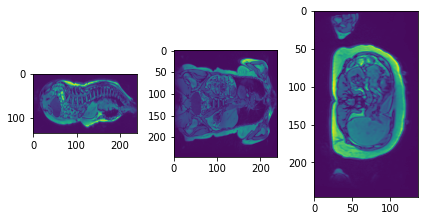

Saving Processed & Stitched Image.....
FINISHED.


In [68]:
print("STARTING KORA.")
print('Reading Volumes.....')
file_to_read1 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz'
file_to_read2 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'kora_ras_sampled_stitched')
print('FINISHED.')

In [69]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/kora/KORA2460249_label/**')

img_ras_list = []
volume = img_ras_sampled_combined
for label_file_to_read in label_files_to_read_list:
    img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
    print(img_ras.shape, label_file_to_read, lidx, labelname)
    mode='nearest'
    img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine], mode=mode)
    
    print(img_ras.shape)
    img_ras_list.append([img_ras, lidx, labelname])

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288) ./datasets/kora/KORA2460249_label/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Pancreas.nrrd 6 PANCREAS
(241, 134, 164)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288) ./datasets/kora/KORA2460249_label/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Adrenal gland(right).nrrd 5 ADRENALGLAND
(241, 134, 164)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288) ./datasets/kora/KORA2460249_label/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd 7 GALLBLADDER
(241, 134, 164)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288) ./datasets/kora/KORA2460249_label/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney(right).nrrd 3 KIDNEY(RIGHT)
(241, 134, 164)
Reading Files.....
Reading NRRD Files.....
Transformin

In [57]:
print(volume.header, stitched_label.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 246 137 239   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -221.36977
qoffset_y       : -172.9664
qoffset_z       : -688.6573
srow_x          : [   2.         0. 

## Pre-Processing

STARTING NAKO.
Reading Volumes.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -664.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -892.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.40625

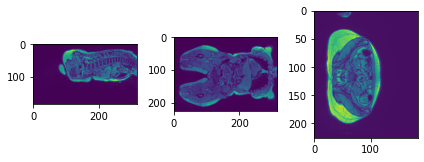

Saving Processed & Stitched Image.....
FINISHED.


In [65]:
# 

print("STARTING NAKO.")
print('Reading Volumes.....')
file_to_read1 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz'
file_to_read2 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz'
file_to_read3 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz'
file_to_read4 = './datasets/nako/100017/100017_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)
img3_ras = read_ras(file_to_read3)
img4_ras = read_ras(file_to_read4)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras, img3_ras, img4_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'nako_ras_sampled_stitched')
print('FINISHED.')

In [66]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/nako/100017_label/**')

img_ras_list = []
volume = img_ras_sampled_combined
for label_file_to_read in label_files_to_read_list:
    img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
    print(img_ras.shape, label_file_to_read, lidx, labelname)
    mode='nearest'
    img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
    print(img_ras.shape)
    img_ras_list.append([img_ras, lidx, labelname])


STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96) ./datasets/nako/100017_label/100017 _3D_GRE_TRA_opp_3D_GRE_TRA_2_subcutaneous.nrrd 8 SUBCUTANEOUS
(226, 184, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96) ./datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas-2.nrrd 6 PANCREAS
(226, 184, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96) ./datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd 9 THYROIDGLAND
(226, 184, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96) ./datasets/nako/100017_label/100017_3D_GTE_TRA_opp_2_nii_Liver-2-3.nrrd 1 LIVER
(226, 184, 96)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(320, 260, 96) ./datasets/nako/100017_label/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2

8 SUBCUTANEOUS
vol offsets: [216.09375, 178.90625, 1132.5]
label_offsets: [232.5, 185.3125, 664.5]
seg start inv v:  [ -9  -4 156] segm end inv v: [217 180 252]
0 -9
1 -4
2 156
updated seg start inv v:  [  0   0 156] updated segm end inv v: [226 184 252]
###############################################################################################
6 PANCREAS
c shape: (226, 184, 96) [[   2.        0.        0.     -232.5   ]
 [   0.        2.        0.     -185.3125]
 [   0.        0.        3.     -664.5   ]
 [   0.        0.        0.        1.    ]]
vol offsets: [216.09375, 178.90625, 1132.5]
label_offsets: [232.5, 185.3125, 664.5]
seg start inv v:  [ -9  -4 156] segm end inv v: [217 180 252]
0 -9
1 -4
2 156
updated seg start inv v:  [  0   0 156] updated segm end inv v: [226 184 252]
###############################################################################################
9 THYROIDGLAND
c shape: (226, 184, 96) [[   2.        0.        0.     -232.5   ]
 [   0.        2.      

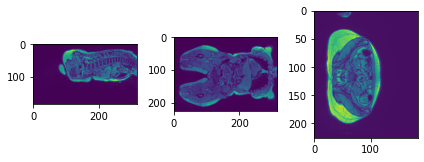

Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.1609375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1325000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


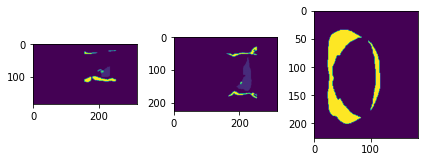

Saving Processed & Stitched Image.....
FINISHED.


In [67]:
volume = img_ras_sampled_combined
volume, stitched_label = label_stitching(img_ras_list, volume)

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(volume))
volume_3_view_viewer(get_volume_data(stitched_label))

print('Saving Processed & Stitched Image.....')
save_volume(volume, 'nako_volume')
save_volume(stitched_label, 'nako_label')
print('FINISHED.')



STARTING UKB.
Reading Volumes.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.    

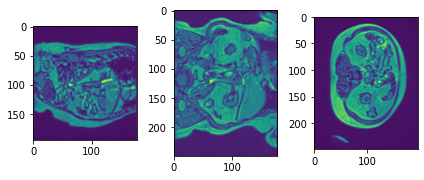

Saving Processed & Stitched Image.....
FINISHED.


In [47]:
print("STARTING UKB.")
print('Reading Volumes.....')
file_to_read1 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz'
file_to_read2 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz'
file_to_read3 = './datasets/ukb/5331775_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)
img3_ras = read_ras(file_to_read3)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras, img3_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'ukb_ras_sampled_stitched')
print('FINISHED.')

In [48]:
print("STARTING UKB LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/ukb/5331775_20201_2_0_label/**')

img_ras_list = []
for label_file_to_read in label_files_to_read_list:
    img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
    print(img_ras.shape, label_file_to_read, lidx, labelname)
    mode='nearest'
    img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    print(img_ras.shape)
    img_ras_list.append([img_ras, lidx, labelname])

STARTING UKB LABEL-MAPS.
Reading Label Maps.....
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81) ./datasets/ukb/5331775_20201_2_0_label/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd 5 ADRENALGLAND
(250, 195, 121)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81) ./datasets/ukb/5331775_20201_2_0_label/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd 5 ADRENALGLAND
(250, 195, 121)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81) ./datasets/ukb/5331775_20201_2_0_label/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd 6 PANCREAS
(250, 195, 121)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81) ./datasets/ukb/5331775_20201_2_0_label/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd 7 GALLBLADDER
(250, 195, 121)
Reading Files.....
Reading NRRD Files.....
Transformin

In [ ]:
volume = img_ras_sampled_combined
volume, stitched_label = label_stitching(img_ras_list, volume)

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(volume))
volume_3_view_viewer(get_volume_data(stitched_label))

print('Saving Processed & Stitched Image.....')
save_volume(volume, 'ukb_volume')
save_volume(stitched_label, 'ukb_label')
print('FINISHED.')

5 ADRENALGLAND
vol offsets: [247.76788, 191.9643, 630.75]
label_offsets: [249.99998, 194.19643, 462.75]
seg start inv v:  [-2 -2 56] segm end inv v: [248 193 177]
0 -2
1 -2
2 56
updated seg start inv v:  [ 0  0 56] updated segm end inv v: [250 195 177]
###############################################################################################
5 ADRENALGLAND
c shape: (250, 195, 121) [[   2.            0.            0.         -249.99998903]
 [   0.            2.            0.         -194.19643164]
 [   0.            0.            3.         -462.75      ]
 [   0.            0.            0.            1.        ]]
vol offsets: [247.76788, 191.9643, 630.75]
label_offsets: [249.99998, 194.19643, 462.75]
seg start inv v:  [-2 -2 56] segm end inv v: [248 193 177]
0 -2
1 -2
2 56
updated seg start inv v:  [ 0  0 56] updated segm end inv v: [250 195 177]
###############################################################################################
6 PANCREAS
c shape: (250, 195, 121) [[  

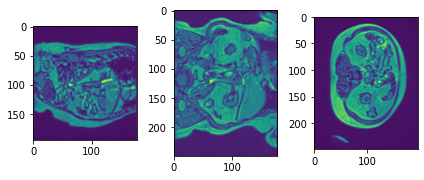

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


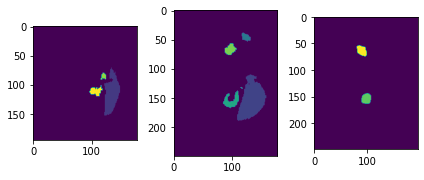

Saving Processed & Stitched Image.....
FINISHED.
